In [2]:
import os.path
from google.colab import files
import io
import pandas as pd
import numpy as np

if not os.path.isfile('Wine_Recognition.csv'):
  uploaded = files.upload()

df = pd.read_csv('Wine_Recognition.csv')

df_noDuplicates = df.drop_duplicates()

df_NumericType = df_noDuplicates.copy()
df_NumericType["wine_type_cat"] = df_NumericType["Wine Type"].astype('category').cat.codes
df_NumericType = df_NumericType.drop(['Wine Type'], axis=1)

df_noType = df_noDuplicates.drop(['Wine Type'], axis=1)

df_normalized=(df_noType-df_noType.mean())/df_noType.std() #note should not be used in model as normalization should use training set values not total values

Saving Wine_Recognition.csv to Wine_Recognition.csv


In [3]:
df_NumericType.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,wine_type_cat
0,7.5,0.530,0.06,2.6,0.086,20.0,44.0,0.9965,3.38,0.59,10.7,0
1,11.1,0.180,0.48,1.5,0.068,7.0,15.0,0.9973,3.22,0.64,10.1,0
2,8.3,0.705,0.12,2.6,0.092,12.0,28.0,0.9994,3.51,0.72,10.0,0
3,7.4,0.670,0.12,1.6,0.186,5.0,21.0,0.9960,3.39,0.54,9.5,0
4,8.4,0.650,0.60,2.1,0.112,12.0,90.0,0.9973,3.20,0.52,9.2,0


Investigating if the dataset has missing attributes:

Links Investigated:

https://rstudio-pubs-static.s3.amazonaws.com/181576_5f67bf5eecab4236a44607d960db7d34.html This link is a breakdown of how one author data cleaned

In [4]:
df_NumericType["wine_type_cat"].unique()

array([0, 1], dtype=int8)

count    1617.000000
mean        0.476809
std         0.499616
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: wine_type_cat, dtype: float64


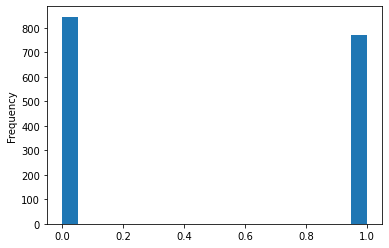

In [5]:
def DescribeAttribute(dataFrame, attributeString, bins = 12):
  print(dataFrame[attributeString].describe())
  dataFrame[attributeString].plot.hist(bins=bins)

DescribeAttribute(df_NumericType, "wine_type_cat", 20)

In [6]:
print("Number of rows where a tuple contains a null value: " + str(len(df_noDuplicates[df_noDuplicates.isnull().any(axis=1)])))
print("Distribution of Wine Types: " + str(len(df_noDuplicates[df_noDuplicates["Wine Type"] == "W"]) / len(df_noDuplicates["Wine Type"]) * 100) + "% White")


Number of rows where a tuple contains a null value: 0
Distribution of Wine Types: 47.680890538033395% White


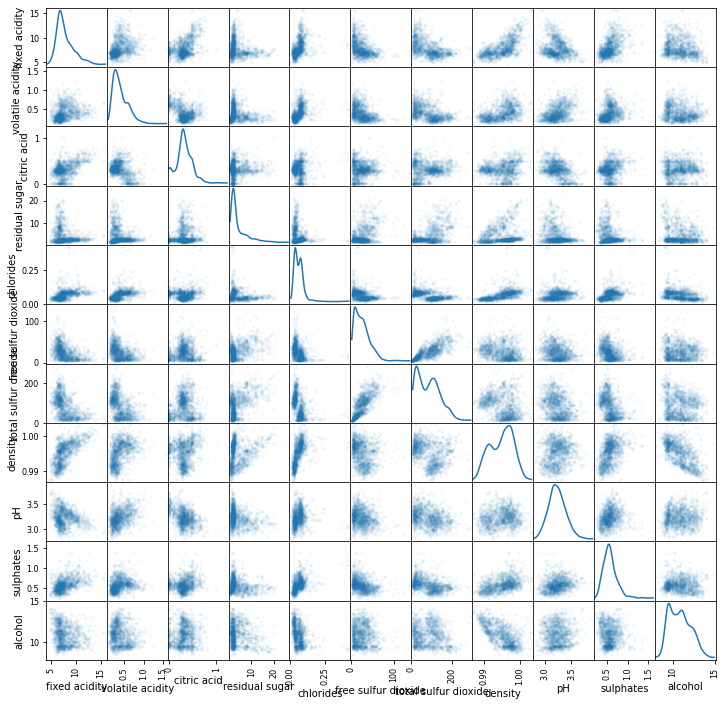

In [7]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_noDuplicates, alpha=0.05, figsize=(12, 12), diagonal="kde");

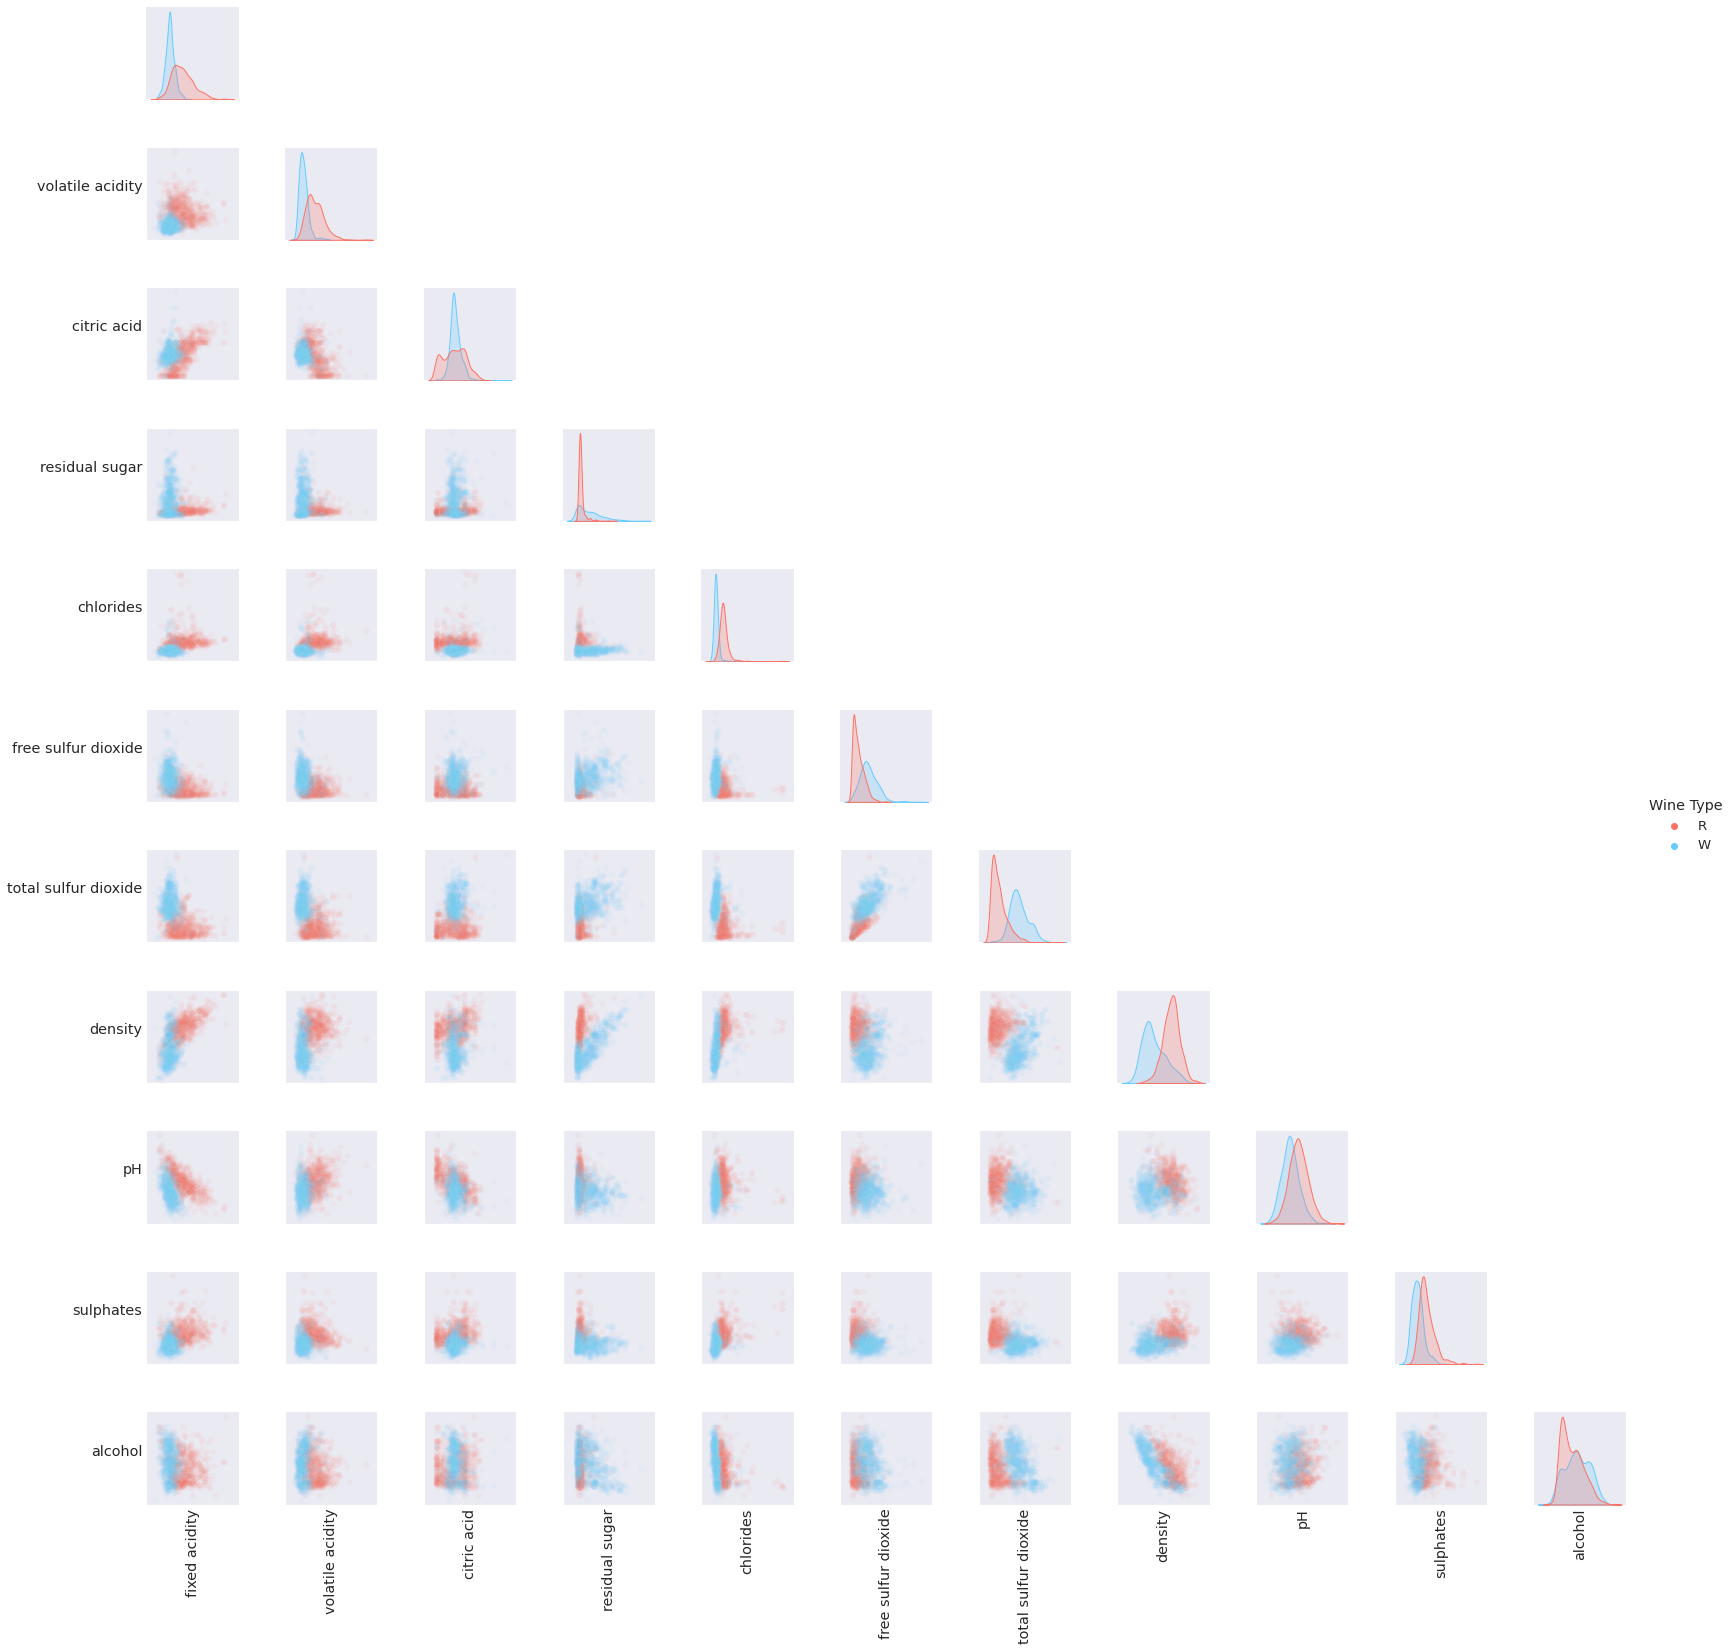

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='white')
sns.set(font_scale = 1.2)
g = sns.pairplot(df_noDuplicates, hue="Wine Type", corner=True, palette={'W':(0.4, 0.8, 1), 'R':(1, 0.45, 0.4)}, height=2, plot_kws=dict(alpha=0.05))
g.set(yticks=[])
g.set(xticks=[])

#from: https://python.tutorialink.com/how-to-rotate-labels-in-a-seaborn-pairgrid/
for ax in g.axes.flat:
    if ax:
        
      # rotate x axis labels
      ax.set_xlabel(ax.get_xlabel(), rotation = 90)
      # rotate y axis labels
      ax.set_ylabel(ax.get_ylabel(), rotation = 0)
      # set y labels alignment
      ax.yaxis.get_label().set_horizontalalignment('right')


In [29]:
import scipy.stats as ss

def PearsonRProabilities(data):
  columns = data.columns
  array = []
  for i in columns:
    tempArr = []
    for j in columns:
      if i == j:
        tempArr.append(1)
      else:
        corr, pvalue = ss.pearsonr(data[i], data[j])
        tempArr.append(round(pvalue, 4))
    array.append(tempArr)
  return array

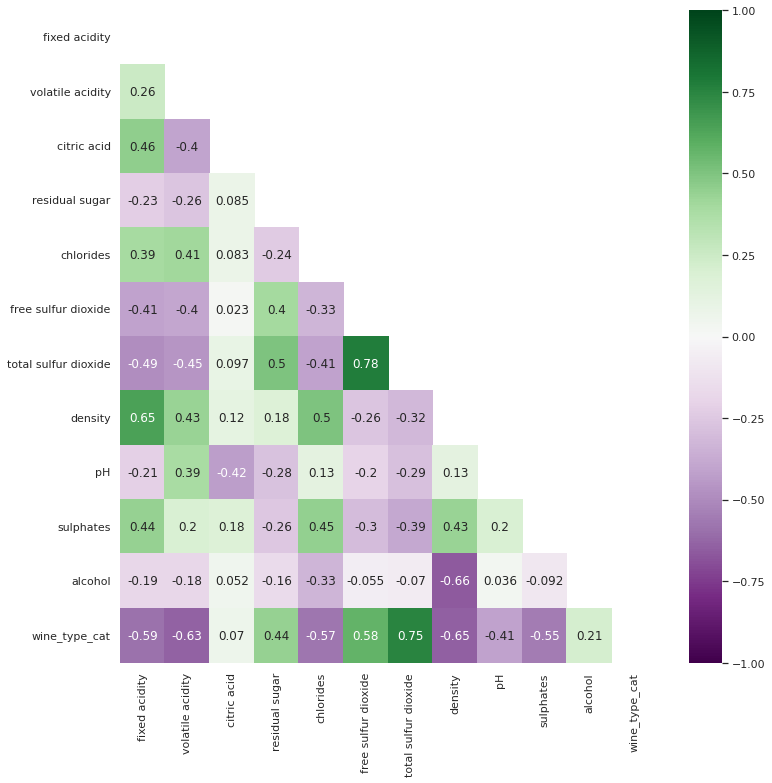

In [27]:
plt.subplots(figsize=(12, 12))
sns.heatmap(df_NumericType.corr(), mask=np.triu(np.ones_like(df_NumericType.corr(), dtype=bool)), annot=True, cmap="PRGn", vmin = -1, vmax = 1)

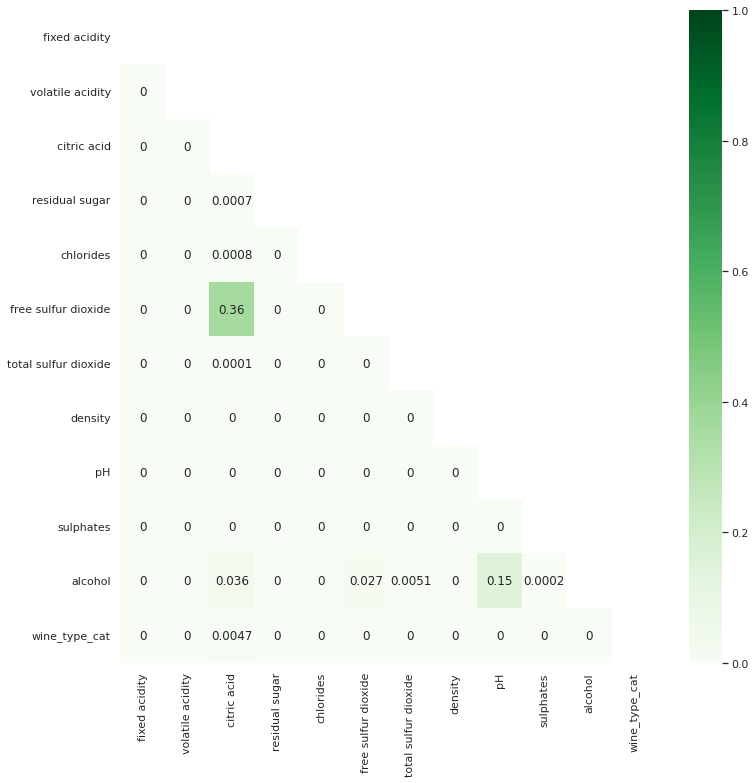

In [30]:
plt.subplots(figsize=(12, 12))
sns.heatmap(
    pd.DataFrame(PearsonRProabilities(df_NumericType), index=df_NumericType.columns, columns=df_NumericType.columns), 
    mask=np.triu(np.ones_like(pd.DataFrame(PearsonRProabilities(df_NumericType), index=df_NumericType.columns, columns=df_NumericType.columns), dtype=bool)), 
    annot=True, cmap="Greens", vmin = 0, vmax = 1)

Interpretation

Citric acid is not strongly assoicated with wine_type so potential candidate for removal. It is also moderately correlated with pH.

Free sulfer dioxide and total sulfer dioxide are strongly assoicated with each other and strongly associated with wine_type hence removing one of these is possible but arguably a bad choice.

Alcohol is weakly correlated with wine_type and strongly correlated with density making it a good candidate for removal .

Model:

Using a feed-forward neural network

Baseline accuracy = 50%

Adapted from: https://www.youtube.com/watch?v=cJ3oqHqRBF0&ab_channel=BadriAdhikari

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer




In [41]:
X_train, X_test, y_train, y_test = train_test_split(df_noType.drop(["alcohol", "citric acid"], axis=1), df_NumericType["wine_type_cat"], test_size=0.33, random_state=42, stratify=df_NumericType["wine_type_cat"].to_numpy()) #shuffle split model
#X_train, X_test, y_train, y_test = train_test_split(df_noType, df_NumericType["wine_type_cat"], test_size=0.33, random_state=42, stratify=df_NumericType["wine_type_cat"].to_numpy()) #shuffle split model
#X_train, X_test, y_train, y_test = train_test_split(df_noType.drop(["alcohol", "citric acid", "free sulfur dioxide"], axis=1), df_NumericType["wine_type_cat"], test_size=0.33, random_state=42, stratify=df_NumericType["wine_type_cat"].to_numpy()) #shuffle split model
#pd.Series(y_test).describe() #shows stratified sampling works

transformer = Normalizer().fit(X_train) #fit apparently does nothing
X_train_norm = transformer.fit_transform(X_train)
X_test_norm = transformer.transform(X_test)

All training code has been functionalized:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 l0 (Dense)                  (None, 9)                 90        
                                                                 
 l1 (Dense)                  (None, 9)                 90        
                                                                 
 output (Dense)              (None, 1)                 10        
                                                                 
Total params: 190
Trainable params: 190
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
11/11 [==============================] - 2s 114ms/step - loss: 0.7085 - accuracy: 0.1422 - val_loss: 0.7045 - val_accuracy: 0.1536
Epoch 2/2000
11/11 [==============================] - 0s 6ms/step - loss: 0.7011 - accuracy: 0.1856 - val_loss: 0.6979 - val_accuracy: 0.2397
Epoch 3/2000
11/11 [================

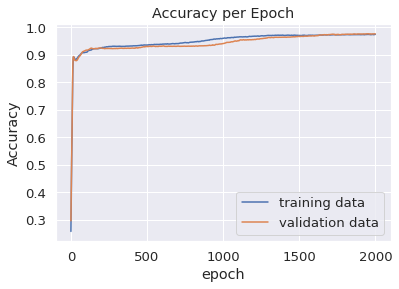



Load Best Model:
34/34 [==============================] - 0s 2ms/step - loss: 0.0830 - accuracy: 0.9741
Model evalutation for training data (verify working model):
[0.08303888887166977, 0.9741458892822266]
17/17 [==============================] - 0s 2ms/step - loss: 0.1065 - accuracy: 0.9775
Model evalutation for test data:
[0.10654230415821075, 0.9775280952453613]




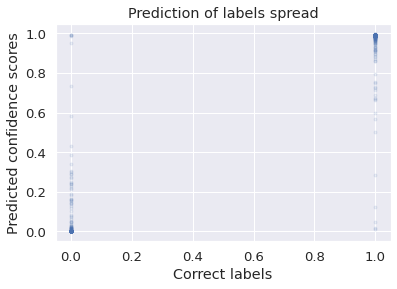



Performance measures:
Accuracy: 97.8%
Precision: 97.3%
Recall: 98.0%
F1: 0.977


(<keras.callbacks.History at 0x7fe235f18390>,
 <keras.engine.sequential.Sequential at 0x7fe239c45990>)

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.ndimage.filters import gaussian_filter1d

def create_model(arrayOfNodes, X_train):
  model = keras.Sequential()
  model.add(layers.Dense(arrayOfNodes[0], input_dim = len(X_train[0,:]),  activation="relu", name="l0"))
  c = 1
  for i in arrayOfNodes[1:]:
    model.add(layers.Dense(i, activation="relu", name="l"+str(c)))
    c += 1
  model.add(layers.Dense(1, name="output", activation='sigmoid'))
  model.summary()
  return model

def run_model(model, patience_in, batch_size_in, epochs_in, X_train, y_train, X_test, y_test):
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  my_callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=patience_in, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='best_model.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min')
  ]

  history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size_in,
    epochs=epochs_in,
    validation_data=(X_test, y_test),
    callbacks=my_callbacks
  )

  return history, model

def model_metrics(history, model, X_train, y_train, X_test, y_test, smooth=False):
  print("History Params:")
  print(history.params)

  print('\n')

  if smooth:
    plt.plot(gaussian_filter1d(history.history['accuracy'], sigma=2))
    plt.plot(gaussian_filter1d(history.history['val_accuracy'], sigma=2))
  else:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
  plt.title('Accuracy per Epoch')
  plt.ylabel('Accuracy')
  plt.xlabel('epoch')
  plt.legend(['training data', 'validation data'], loc='lower right')
  plt.show()

  print('\n')

  print("Load Best Model:")
  model.load_weights("best_model.hdf5")
  scores = model.evaluate(X_train, y_train)
  print("Model evalutation for training data (verify working model):")
  print(scores)
  scores = model.evaluate(X_test, y_test)
  print("Model evalutation for test data:")
  print(scores)

  print('\n')

  prediction = model.predict(X_test)
  plt.plot(y_test, prediction, '.', alpha=0.1)
  plt.title('Prediction of labels spread')
  plt.xlabel('Correct labels')
  plt.ylabel('Predicted confidence scores')
  plt.show()

  print('\n')

  accuracy = accuracy_score(y_test, prediction.flatten().round())
  precision = precision_score(y_test, prediction.flatten().round())
  recall = recall_score(y_test, prediction.flatten().round())
  f1 = f1_score(y_test, prediction.flatten().round())

  print("Performance measures:")
  print("Accuracy: " + str(round(accuracy * 100, 1)) + "%")
  print("Precision: " + str(round(precision * 100,1)) + "%")
  print("Recall: " + str(round(recall * 100,1)) + "%")
  print("F1: " + str(round(f1,3)))

def create_run_model(X_train, y_train, X_test, y_test, shape_array, patience, batch_size, epochs, evaluate=False):
  history, model = run_model(create_model(shape_array, X_train), patience, batch_size, epochs, X_train, y_train, X_test, y_test)
  model.load_weights("best_model.hdf5")
  if evaluate:
    if epochs > 500:
      model_metrics(history, model, X_train, y_train, X_test, y_test, smooth=True)
    else:
      model_metrics(history, model, X_train, y_train, X_test, y_test)
  return history, model

def get_pre_model(shape_array, X_train, name):
  m = create_model(shape_array, X_train)
  m.load_weights(name)
  return m

create_run_model(X_train_norm, y_train, X_test_norm, y_test, [9,9], 200, 100, 2000, evaluate=True)
#history, model = create_run_model(X_test_norm, y_test, [9,9], 200, 100, 2000, evaluate=True)

In [46]:
files.download('best_model.hdf5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ensemble model attempt

Planned models

*   9x9x1 1000 iterations - high accuracy (highly fitted)
*   9x9...9x9x1 1000 iterations - deep network
*   Random Forest
*   Support Vector Machine





In [47]:
#create models
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB

def svm_classifier(X_train, y_train, X_test):
  clf = svm.SVC(kernel='rbf')
  clf.fit(X_train, y_train)
  return clf.predict(X_test)

def random_forest_classifier(X_train, y_train, estimators):
  clf = RandomForestClassifier(n_estimators=estimators, random_state=0)
  clf.fit(X_train, y_train)
  return clf

def random_forest_regression(X_train, y_train, X_test):
  clf = RandomForestRegressor(max_depth=2, random_state=0)
  clf.fit(X_train, y_train)
  return clf.predict(X_test).round()

def output_statistics(predicted, real):
  print(confusion_matrix(predicted, real))
  print(classification_report(predicted, real))
  print(accuracy_score(predicted, real))

  accuracy = accuracy_score(real, predicted)
  precision = precision_score(real, predicted)
  recall = recall_score(real, predicted)
  f1 = f1_score(real, predicted)

  print("Performance measures:")
  print("Accuracy: " + str(round(accuracy * 100, 1)) + "%")
  print("Precision: " + str(round(precision * 100,1)) + "%")
  print("Recall: " + str(round(recall * 100,1)) + "%")
  print("F1: " + str(round(f1,3)))


def train_meta_model(X_train, y_train, X_test, y_test):
  #rf_clf = RandomForestClassifier(n_estimators=6, random_state=0)
  rf_clf = RandomForestRegressor(max_depth=10, random_state=0)
  rf_clf.fit(X_train, y_train)

  print("RF for run: ")
  output_statistics(rf_clf.predict(X_test).round(), y_test)

  print("NN for run: ")
  nn_history, nn_model = create_run_model(X_train, y_train, X_test, y_test, [9,9], 200, 100, 2000, evaluate=True)
  #nn_model = get_pre_model([9,9], X_train, "best_model.hdf5")

  #a = pd.DataFrame({'nn': nn_model.predict(X_train).flatten(), 'rf': rf_clf.predict(X_train), 'svm': svm_clf.predict(X_train), 'gnb': gnb.predict(X_train)}, columns=['nn', 'rf', 'svm', 'gnb']).reset_index(drop=True)
  #b = pd.DataFrame({'nn': nn_model.predict(X_test).flatten(), 'rf': rf_clf.predict(X_test), 'svm': svm_clf.predict(X_test), 'gnb': gnb.predict(X_test)}, columns=['nn', 'rf', 'svm', 'gnb']).reset_index(drop=True)
  #aa = a.join(pd.DataFrame(X_train_norm))
  #bb = b.join(pd.DataFrame(X_test_norm))
  a = pd.DataFrame({'nn': nn_model.predict(X_train).flatten(), 'rf': rf_clf.predict(X_train)}, columns=['nn', 'rf']).reset_index(drop=True)
  b = pd.DataFrame({'nn': nn_model.predict(X_test).flatten(), 'rf': rf_clf.predict(X_test)}, columns=['nn', 'rf']).reset_index(drop=True)
  print(len(a))
  print(len(b))
  #print(a)
  #print(b)

  #meta_model = get_pre_model(, a.to_numpy(), "best_model.hdf5")
  #nn_history, meta_model = create_run_model(a.to_numpy(), y_train, b.to_numpy(), y_test, [1000,1000,1000,1000], 200, 100, 5000, evaluate=True)
  #output_statistics(meta_model.predict(b).flatten().round(), y_test)

  print("Final Stats for run: ")
  nn_history, meta_model = create_run_model(a.to_numpy(), y_train, b.to_numpy(), y_test, [5,5,5], 200, 100, 2000, evaluate=True)
  output_statistics(meta_model.predict(b).flatten().round(), y_test)

  #c = pd.DataFrame({'expected': meta_model.predict(bb).flatten(), 'real': y_test}, columns=['expected', 'real']).reset_index(drop=True)

  #d = c.join(b).sort_values(by=['expected', 'nn', 'rf'])
  #pd.merge(b, c, left_on=True)
  #print(d[d['expected'].round() != d['real']])
  return meta_model

#output_statistics(random_forest_classifier(X_train_norm, y_train, X_test_norm), y_test)

#train_meta_model(X_train_norm, y_train, X_test_norm, y_test)

#print(random_forest_regression(X_train_norm, y_train, X_test_norm))


RF for run: 
[[272  12]
 [  7 243]]
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97       284
         1.0       0.95      0.97      0.96       250

    accuracy                           0.96       534
   macro avg       0.96      0.96      0.96       534
weighted avg       0.96      0.96      0.96       534

0.9644194756554307
Performance measures:
Accuracy: 96.4%
Precision: 97.2%
Recall: 95.3%
F1: 0.962
NN for run: 
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 l0 (Dense)                  (None, 9)                 90        
                                                                 
 l1 (Dense)                  (None, 9)                 90        
                                                                 
 output (Dense)              (None, 1)                 10        
                                          

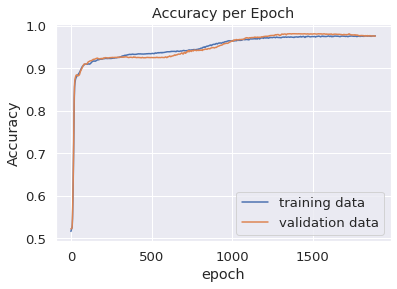



Load Best Model:
34/34 [==============================] - 0s 2ms/step - loss: 0.0790 - accuracy: 0.9751
Model evalutation for training data (verify working model):
[0.07898692786693573, 0.9750692248344421]
17/17 [==============================] - 0s 2ms/step - loss: 0.0944 - accuracy: 0.9813
Model evalutation for test data:
[0.0943620502948761, 0.9812734127044678]




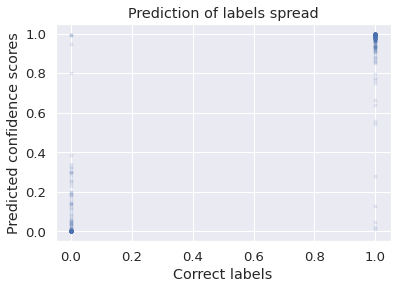



Performance measures:
Accuracy: 98.1%
Precision: 98.0%
Recall: 98.0%
F1: 0.98
1083
534
Final Stats for run: 
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 l0 (Dense)                  (None, 5)                 15        
                                                                 
 l1 (Dense)                  (None, 5)                 30        
                                                                 
 l2 (Dense)                  (None, 5)                 30        
                                                                 
 output (Dense)              (None, 1)                 6         
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
11/11 [==============================] - 1s 22ms/step - loss: 0.68

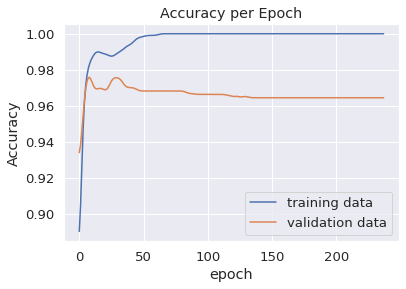



Load Best Model:
34/34 [==============================] - 0s 1ms/step - loss: 0.0323 - accuracy: 0.9935
Model evalutation for training data (verify working model):
[0.03231341019272804, 0.9935364723205566]
17/17 [==============================] - 0s 2ms/step - loss: 0.0943 - accuracy: 0.9700
Model evalutation for test data:
[0.09427399933338165, 0.9700374603271484]




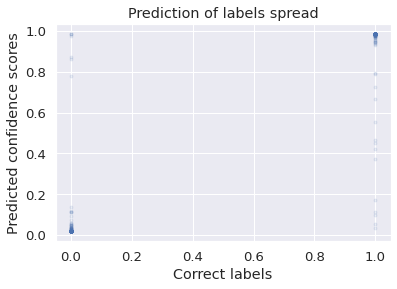



Performance measures:
Accuracy: 97.0%
Precision: 97.2%
Recall: 96.5%
F1: 0.969
[[272   9]
 [  7 246]]
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       281
         1.0       0.96      0.97      0.97       253

    accuracy                           0.97       534
   macro avg       0.97      0.97      0.97       534
weighted avg       0.97      0.97      0.97       534

0.9700374531835206
Performance measures:
Accuracy: 97.0%
Precision: 97.2%
Recall: 96.5%
F1: 0.969


In [49]:
train_meta_model(X_train_norm, y_train, X_test_norm, y_test)

In [50]:
def get_data():
  data = []
  num = []
  
  for n in range(1,200):
    data.append(random_forest_classifier(X_train_norm, y_train, n).score(X_test_norm, y_test))
    num.append(n)
  return pd.DataFrame({'data': data, 'estimators': num}, columns=['data', 'estimators']).reset_index(drop=True)


d = get_data()


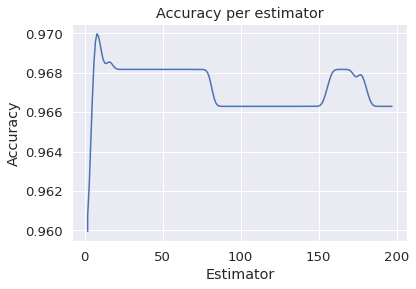

In [51]:
plt.plot(gaussian_filter1d(d['estimators'], sigma=2), gaussian_filter1d(d['data'], sigma=2), alpha=1)
plt.title('Accuracy per estimator')
plt.xlabel('Estimator')
plt.ylabel('Accuracy')
plt.show()


In [58]:
from sklearn.model_selection import StratifiedKFold

def kfold(X, y):
  skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
  scores = []
  n = 0
  for train_index, test_index in skf.split(X,y): 
      print("Train:", len(train_index), "Validation:", len(test_index)) 
      X_train, X_test = X[train_index], X[test_index ] 
      y_train, y_test = y[train_index], y[test_index ]

      transformer = Normalizer().fit(X_train) #fit apparently does nothing
      X_train_norm = transformer.fit_transform(X_train)
      X_test_norm = transformer.transform(X_test)

      rf_clf = RandomForestClassifier(n_estimators=6, random_state=0)
      rf_clf.fit(X_train_norm, y_train)

      nn_history, nn_model = create_run_model(X_train_norm, y_train, X_test_norm, y_test, [9,9], 200, 100, 1000, evaluate=False)
      nn_model.save_weights("model" + str(n) + ".hdf5")
      #nn_model = get_pre_model([9,9], X_train_norm, "model"+str(n)+ ".hdf5")
      
      scores.append(pd.DataFrame({"nn": nn_model.predict(X_test_norm).flatten(), "rf": rf_clf.predict(X_test_norm), "truth": y_test}))
      n += 1
  return scores



In [59]:
output = kfold(df_noType.drop(["alcohol", "citric acid"], axis=1).to_numpy(), df_NumericType["wine_type_cat"].to_numpy())



Streaming output truncated to the last 5000 lines.
15/15 [==============================] - 0s 5ms/step - loss: 0.1509 - accuracy: 0.9457 - val_loss: 0.2541 - val_accuracy: 0.9193
Epoch 540/1000
15/15 [==============================] - 0s 7ms/step - loss: 0.1519 - accuracy: 0.9430 - val_loss: 0.2523 - val_accuracy: 0.9193
Epoch 541/1000
15/15 [==============================] - 0s 6ms/step - loss: 0.1513 - accuracy: 0.9444 - val_loss: 0.2529 - val_accuracy: 0.9193
Epoch 542/1000
15/15 [==============================] - 0s 6ms/step - loss: 0.1504 - accuracy: 0.9444 - val_loss: 0.2526 - val_accuracy: 0.9193
Epoch 543/1000
15/15 [==============================] - 0s 8ms/step - loss: 0.1502 - accuracy: 0.9457 - val_loss: 0.2493 - val_accuracy: 0.9317
Epoch 544/1000
15/15 [==============================] - 0s 5ms/step - loss: 0.1504 - accuracy: 0.9464 - val_loss: 0.2545 - val_accuracy: 0.9193
Epoch 545/1000
15/15 [==============================] - 0s 6ms/step - loss: 0.1506 - accuracy: 0.945

In [60]:
totalScore = output[0]

print(totalScore)
for o in output[1:]:
  print(len(o))
  totalScore = pd.concat([totalScore,o])
  #totalScore.append(o, ignore_index=True)
output_statistics(totalScore["nn"].round(), totalScore["truth"])
output_statistics(totalScore["rf"], totalScore["truth"])



           nn  rf  truth
0    0.002050   0      0
1    0.438273   0      0
2    0.000121   0      0
3    0.000005   0      0
4    0.000506   0      0
..        ...  ..    ...
157  0.968459   1      1
158  0.997492   1      1
159  0.997279   1      1
160  0.948973   1      1
161  0.987763   1      1

[162 rows x 3 columns]
162
162
162
162
162
162
161
161
161
[[820  23]
 [ 26 748]]
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       843
         1.0       0.97      0.97      0.97       774

    accuracy                           0.97      1617
   macro avg       0.97      0.97      0.97      1617
weighted avg       0.97      0.97      0.97      1617

0.9696969696969697
Performance measures:
Accuracy: 97.0%
Precision: 96.6%
Recall: 97.0%
F1: 0.968
[[831  31]
 [ 15 740]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       862
           1       0.96      0.98      0.97       755

    a

In [ ]:
totalScore


,nn,rf,truth
0,2.889633e-04,0,0
1,2.225619e-01,0,0
2,5.588671e-07,0,0
3,8.909676e-07,0,0
4,4.666825e-05,0,0
...,...,...,...
156,9.932001e-01,1,1
157,9.244934e-01,1,1
158,9.957209e-01,1,1
159,9.952744e-01,1,1


AUC: 0.971


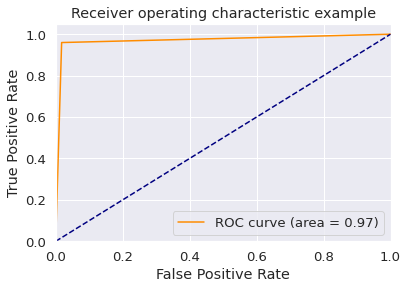

In [61]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(totalScore['truth'], totalScore['rf'])
roc_auc = auc(fpr, tpr)

plt.figure()

plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()